In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# IMPORTS
import csv
import re
import zipfile
import pickle
import os
from io import BytesIO
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
plt.style.use('ggplot')

import spacy
#python -m spacy download el_core_news_sm -- rin in cmd
nlp = spacy.load("el_core_news_sm")
nlp.max_length = 3000000

import nltk
#nltk.download("punkt")
import string
from nltk import WhitespaceTokenizer

from gensim.models import KeyedVectors, Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader

import pickle

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
gpu = f" Device type: {torch.cuda.get_device_name()}." if device=='cuda' else ""
print(f"Device is {device}."+gpu )

Device is cuda. Device type: NVIDIA GeForce RTX 3060.


In [5]:
#Creating dictionaries to use in the confusion matrix

#Defining dictionary for 10 types of clases
classes = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4',
               5:'5', 6:'6', 7:'7', 8:'8', 9:'9'}

#Defining dictionary that holds two types of model
models = {0: "Naive Bayes",1: "Random Forest",2: "LightGBM",3: "Logistic Regression",4: "MLP",5 : "CNN"}

In [6]:
#Building function to plot the confusion matrix as a heatmap
def conf_matr(y_t,y_pred,class_index,classes_dict=classes,model_dict=models):
    #Confusion matrix
    conf_m = confusion_matrix(y_t,y_pred)

    #Building data frame to 
    df_cm = pd.DataFrame(conf_m, index = [i for i in classes_dict.values()],
                  columns = [i for i in classes_dict.values()])
    fig,ax = plt.subplots(figsize=(10,10))
    sns.heatmap(df_cm, annot=True, cmap='Greens',fmt='.3g',cbar=False)
    
    ax.set_xlabel('Predicted classes', fontsize=14, weight='bold')
    ax.set_ylabel('True classes', fontsize=14, weight='bold')
    ax.set_title(f'Confusion matrix of {model_dict[class_index]} classifier', fontsize=17, weight='bold')

    plt.show()

In [7]:
# Read training data
train_domains = list()
y_train = list()
with open("train.txt", "r") as f:
    for line in f:
        l = line.split(",")
        train_domains.append(l[0])
        y_train.append(l[1][:-1])
y_train = np.array(list(map(int, y_train)))

# Read test data
test_domains = list()
with open("test.txt", "r") as f:
    for line in f:
        l = line.split(",")
        test_domains.append(l[0])

In [8]:
#LOAD DATA
with open('X_train_text', 'rb') as handle:
    X_train_text = pickle.load(handle)
with open('X_train_graph_n2v', 'rb') as handle:
    X_train_graph = pickle.load(handle)    
    
with open('X_test_text', 'rb') as handle:
    X_test_text = pickle.load(handle)
with open('X_test_graph_n2v', 'rb') as handle:
    X_test_graph = pickle.load(handle)
    
#X_train = np.hstack((X_train_text, X_train_graph))

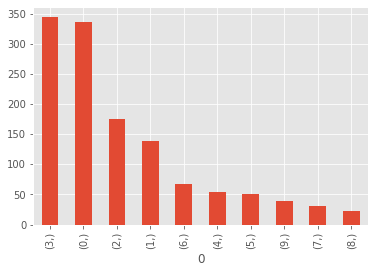

In [9]:
pd.DataFrame(y_train).value_counts().plot.bar(); #imbalanced dataset

### Train - We work only with train data

In [10]:
#Step 1: Train and test seperately
X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(
    X_train_text, y_train, test_size=0.2, random_state=123, stratify=y_train)
X_train_graph, X_val_graph, y_train_graph, y_val_graph = train_test_split(
    X_train_graph, y_train, test_size=0.2, random_state=123, stratify=y_train)

In [11]:
#Step 2: Scaling the Data, only for graph (text data are encoded)

scaler = StandardScaler()
#X_train_text = scaler.fit_transform(X_train_text)
X_train_graph = scaler.fit_transform(X_train_graph)
#X_test_text = scaler.transform(X_test_text)
X_val_graph = scaler.transform(X_val_graph)
X_test_graph = scaler.transform(X_test_graph)

In [12]:
X_train_text_new = X_train_text
y_train_text_new = y_train_text
X_train_graph_new = X_train_graph
y_train_graph_new = y_train_graph

In [13]:
def load_embeddings(fname, vocab):
    '''Loads embeddings from pretrained model'''
    embeddings = np.zeros((len(vocab)+1, 300))
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    for word in vocab:
        if word in model:
            embeddings[vocab[word]] = model[word]
        else:
            embeddings[vocab[word]] = np.random.uniform(-0.25, 0.25, 300)

    return embeddings

In [14]:
# Create embedding matrix
path_to_embeddings = 'grcorpus_def.vec.gz'
if os.path.exists('./EMBEDDINGS.pkl'):
    with open('./EMBEDDINGS.pkl', 'rb') as h:
        embeddings = pickle.load(h)
else:
    embeddings = load_embeddings(path_to_embeddings, vocab)
    with open('./EMBEDDINGS.pkl', 'wb') as h:
        embeddings = pickle.dump(embeddings, h)

In [15]:
#Hyperparameters
batch_size = 12
hidden_dim = 64
n_classes = 10
n_epochs = 200
input_dim = X_train_graph_new.shape[1]
dropout = 0.5

kernel_sizes = [3,4]
n_filters = 40
static = True

In [16]:
list_of_parts_and_labels = []
for data,label in zip(zip(X_train_text_new, X_train_graph_new), y_train_text_new):
    parts = [torch.LongTensor(data[0]), torch.FloatTensor(data[1])]
    list_of_parts_and_labels.append([*parts, torch.tensor(label)])
    
train_loader = torch.utils.data.DataLoader(list_of_parts_and_labels,
               shuffle = True, batch_size = batch_size)

list_of_parts_and_labels_val = []
for data,labels in zip(zip(X_val_text, X_val_graph), y_val_text):
    parts = [torch.LongTensor(data[0]), torch.FloatTensor(data[1])]
    list_of_parts_and_labels_val.append([*parts, torch.tensor(label)])
    
val_loader = torch.utils.data.DataLoader(list_of_parts_and_labels_val,
            shuffle = True, batch_size = batch_size)


In [17]:
class kmodel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_filters, kernel_sizes, dropout, embeddings, static):
        super(kmodel, self).__init__()
        
        #CNN PART
        self.embedding = nn.Embedding(embeddings.shape[0], embeddings.shape[1])
        self.embedding.weight.data.copy_(torch.from_numpy(embeddings))
        if static:
            self.embedding.weight.requires_grad = False
        self.convs = nn.ModuleList([nn.Conv2d(1, n_filters, (K, embeddings.shape[1])) for K in kernel_sizes])
        self.fc1 = nn.Linear(len(kernel_sizes) * n_filters, n_classes)
        
        #GNN PART
        self.fc2 = nn.Linear(input_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, n_classes)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        self.comb = nn.Linear(20,10)

    
    def forward(self, text_input, graph_input):
        t = self.text_layers(text_input)
        g = self.graph_layers(graph_input)
        #print(t.shape, g.shape)
        combined = torch.cat((t, g), dim=1)

        z = self.comb(combined)
        z = self.relu(z)
        
        #return z
        return F.log_softmax(z, dim=1) #z
    
    def text_layers(self,x):
        '''Implement the CNN'''
        x = self.embedding(x)
        x = x.unsqueeze(1)
        lst = list()
        for i in range(len(self.convs)):
            t = self.relu(self.convs[i](x))
            t = t.squeeze()
            # t.size(2)
            t = F.max_pool1d(t, t.size(2)).squeeze()
            lst.append(t)

        x = torch.cat(lst, dim=1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x
    
    def graph_layers(self,y):
        '''Implement the GNN'''
        y = self.fc2(y)
        h1 = self.relu(y)
        h1 = self.dropout(h1)

        #h2 = self.fc3(h1)
        #h2  = self.relu(h2)
        #h2 = self.dropout(h2)
        y = self.fc4(h1)
        return y    

In [18]:
def _train_step(model, optimizer, loss_fn):
    
    def step(x1,x2, y):
        model.train()
        output = model(x1,x2)
        loss = loss_fn(output, y.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    
    return step      

def _eval_step(model, loss_fn):
    
    def step(x1,x2, y):
        model.eval()
        pred = model(x1,x2)
        loss = loss_fn(pred, y.long())
        return loss.item()
    
    return step  

In [19]:
from sklearn.utils import class_weight
class_weights=class_weight.compute_class_weight('balanced',np.unique(y_train_text_new),y_train_text_new)
class_weights=torch.tensor(class_weights,dtype=torch.float)

/opt/venv/causal/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6 7 8 9], y=[0 3 2 ... 5 3 2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [20]:
model = kmodel(input_dim, hidden_dim, n_classes, n_filters, kernel_sizes, dropout, embeddings, static)
loss_fn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(params=model.parameters(), lr=0.0001)

In [21]:
model = model.to(device)
train_step = _train_step(model, optimizer, loss_fn)
eval_step = _eval_step(model, loss_fn)

train_loss = []
eval_loss = []
best_val_loss = 100

for epoch in range(n_epochs):
    t_loss = []
    e_loss = []
    loss = 0
    for data in train_loader: #apo edw pairnei ta data
        text_input, graph_input, labels = data 
        graph_input = graph_input.to(device)
        text_input = text_input.to(device)
        labels = labels.to(device)

        
        loss = train_step(text_input, graph_input, labels)
        t_loss.append(loss)
    train_loss.append(np.mean(t_loss))   
    
    loss = 0
    for data in val_loader: #apo edw pairnei ta data
        text_input, graph_input, labels = data 
        graph_input = graph_input.to(device)
        text_input = text_input.to(device)
        labels = labels.to(device)
        
        loss = eval_step(text_input, graph_input, labels)
        e_loss.append(loss)
    eval_loss.append(np.mean(e_loss))

    # Remember best validation loss and save checkpoint
    is_best = loss <= best_val_loss
    best_val_loss = min(loss, best_val_loss)
    if is_best:
        torch.save({
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, 'model_best.pth.tar')
        
    if epoch%20 == 0:
        print(f'Epoch: {epoch:>3}, Train Loss: {train_loss[-1]:.4f}, Validation Loss: {eval_loss[-1]:.4f}')

Epoch:   0, Train Loss: 2.3086, Validation Loss: 2.3464
Epoch:  20, Train Loss: 1.9222, Validation Loss: 2.3120
Epoch:  40, Train Loss: 1.4126, Validation Loss: 2.3298
Epoch:  60, Train Loss: 1.0663, Validation Loss: 2.4891
Epoch:  80, Train Loss: 0.8635, Validation Loss: 2.5440
Epoch: 100, Train Loss: 0.7169, Validation Loss: 2.6848
Epoch: 120, Train Loss: 0.6420, Validation Loss: 2.7804
Epoch: 140, Train Loss: 0.6303, Validation Loss: 2.8491
Epoch: 160, Train Loss: 0.5298, Validation Loss: 2.9210
Epoch: 180, Train Loss: 0.4980, Validation Loss: 3.0593


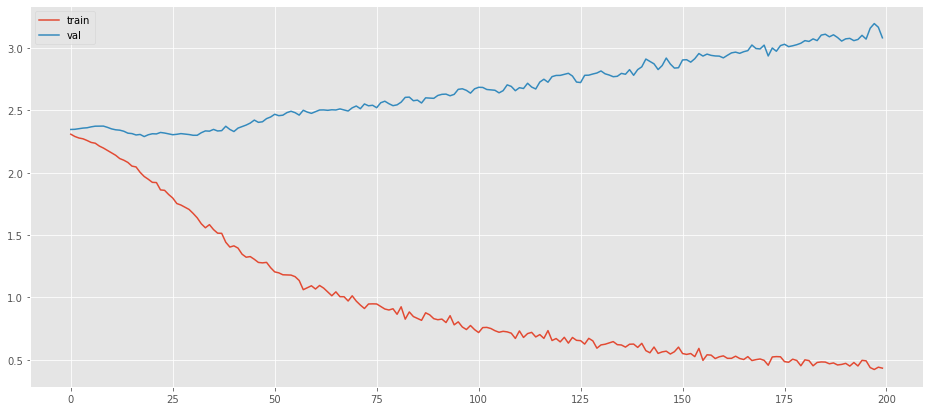

In [22]:
fig, ax =plt.subplots(figsize=(16, 7))
ax.plot(train_loss, label='train')
ax.plot(eval_loss, label='val')
plt.legend();

In [23]:
# Make predictions
checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
y_pred = list()
for data in val_loader: #apo edw pairnei ta data
    text_input, graph_input, labels = data 
    graph_input = graph_input.to(device)
    text_input = text_input.to(device)

    output = model(text_input, graph_input)
    y_pred.append(torch.exp(output))
    
y_preds = torch.cat(y_pred, dim=0).detach().cpu().numpy()
accuracy_score(y_preds.argmax(axis=1), y_val_text)

0.14682539682539683

In [25]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(np.array(list(map(int, y_val_text))), y_preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.27      0.22      0.24        67
           1       0.06      0.07      0.07        28
           2       0.12      0.17      0.14        35
           3       0.20      0.19      0.20        69
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        10
           6       0.10      0.07      0.08        14
           7       0.00      0.00      0.00         6
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         8

    accuracy                           0.15       252
   macro avg       0.08      0.07      0.07       252
weighted avg       0.16      0.15      0.15       252



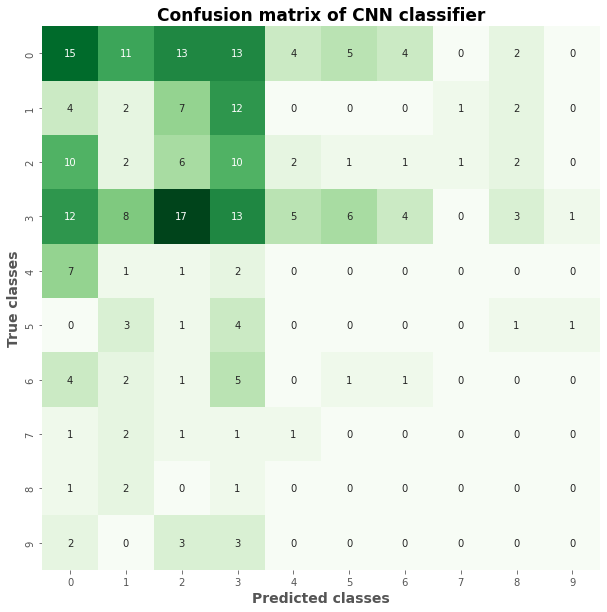

In [27]:
conf_matr(np.array(list(map(int, y_val_text))), y_preds.argmax(axis=1),5)

In [28]:
list_of_parts_and_labels_test = []
for data in zip(X_test_text, X_test_graph):
    parts = [torch.LongTensor(data[0]), torch.FloatTensor(data[1])]
    list_of_parts_and_labels_test.append([*parts])
    
test_loader = torch.utils.data.DataLoader(list_of_parts_and_labels_test,
            shuffle = True, batch_size = batch_size)

In [29]:
# Make predictions
checkpoint = torch.load('model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
y_pred = list()
for x in test_loader:
    text_input = x[0].to(device)
    graph_input = x[1].to(device)
    
    output = model(text_input, graph_input)
    y_pred.append(torch.exp(output))
y_pred = torch.cat(y_pred, dim=0).detach().cpu().numpy()

In [30]:
# Write predictions to a file
with open('sample_submission.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = list()
    for i in range(10):
        lst.append('class_'+str(i))
    lst.insert(0, "domain_name")
    writer.writerow(lst)
    for i,test_domain in enumerate(test_domains):
        lst = y_pred[i,:].tolist()
        lst.insert(0, test_domain)
        writer.writerow(lst)